___

<a href='http://www.pieriandata.com'><img src='../COURSE_NOTEBOOKS/Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright by Pierian Data Inc.</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Keras RL DQN on Image Environment - Exercise - 




In thise notebook you will implement a DQN agent on the famous game of Pong:
**Use the Pong-v0 environment**
(https://gym.openai.com/envs/Pong-v0/) <br />

**TASK: Import necessary libraries and create the environment. Also extract the possible actions** <br />

In [21]:
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import gym
from gym.utils.play import play

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Permute, Dense, Activation
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
env = gym.make("Pong-v0")
nb_actions = env.action_space.n
nb_actions

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing e

6

**TASK: Play the game manually (keys: a and d to move the bars)** <br />

In [3]:
#play(env)

In [4]:
env.reset()

action = env.action_space.sample()
observation, reward, done, info = env.step(action)

env.close()

c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\utils\passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


In [5]:
observation.shape

(210, 160, 3)

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


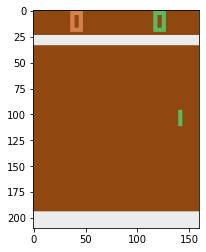

In [19]:
%matplotlib inline

plt.imshow(observation)

**TASK: Define an input size and the window length** <br />

In [55]:
WINDOW_LENGTH = 4
IMG_SHAPE = (84, 84)
INPUT_SHAPE = (WINDOW_LENGTH, *IMG_SHAPE)

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
INPUT_SHAPE

(4, 84, 84)

**TASK: Create the ImageProcessor** <br />
It needs to:
1. Resize the image
2. Convert it to grayscale
3. Standardize it
4. Be memory efficient

Dont forget the reward clipping

In [52]:
class ImageProcessor(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = img.resize(IMG_SHAPE)
        img = img.convert("L")
        img = np.array(img)
        return img.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.0
        return processed_batch

**TASK: Design the Convolutional Neural Network** <br />
Hint: Make sure to get the right input shape!

You can try the same architecture than presented in the previous notebook:
1. Conv2D(filters=32, kernel_size=8, stride=4)
2. Conv2D(filters=64, kernel_size=4, stride=2)
3. Conv2D(filters=64, kernel_size=3, stride=1)
4. Dense(512)

Dont forget the activation function

In [57]:
model = Sequential()

model.add(Permute((2,3,1), input_shape=INPUT_SHAPE))

model.add(Convolution2D(filters=32, kernel_size=(8,8), strides=(4,4), kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Convolution2D(filters=64, kernel_size=(4,4), strides=(2,2), kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Convolution2D(filters=64, kernel_size=(3,3), strides=(1,1), kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(nb_actions))
model.add(Activation('linear'))


In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        2080      
_________________________________________________________________
activation_5 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
activation_7 (Activation)    (None, 9, 9, 64)         

**TASK: Create the Replay Memory** <br />


In [27]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**TASK: Create the processor** <br />


In [28]:
processor = ImageProcessor()

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**TASK: Define the action selection policy.** <br />
Feel free to try all policies you like. (Hint: decaying epsilon greedy also works here)

In [44]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                                attr='eps',
                                value_max=1.0,
                                value_min=0.1,
                                value_test=0.05,
                                nb_steps=1000000)

**TASK: Create the agent.** <br />
Dont forget to compile!

In [45]:
dqn = DQNAgent(model=model, policy=policy, memory=memory,
                processor=processor, nb_actions=nb_actions,
                nb_steps_warmup=50000, gamma=0.99, target_model_update=10000,
                train_interval=4, delta_clip=1)

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
dqn.compile(optimizer=Adam(lr=25e-5), metrics=['mae'])

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\Users\tobia\.conda\envs\ai\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [38]:
25e-5

0.00025

**TASK: Define a checkpoint callback to store the weights during training.** <br />
Please name it differently than our provided checkpoint to avoid overwriting it

In [48]:
weights_filename = "dqn_student_weights.h5f"
checkpoint_filename = "dqn_checkpoint_weights.h5f"

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
checkpoint_callback = ModelIntervalCheckpoint(checkpoint_filename, interval=100000)

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**TASK: Train the agent.** <br />

In [14]:
dqn.fit(env=env, nb_steps=1500000, visualize=False, callbacks=[checkpoint_callback], visualize=False, log_interval=10000)

In [ ]:
dqn.save_weights(weights_filename, overwrite=True)

**TASK: Evaluate the agent.** <br />

In [15]:
dqn.test(env=env, nb_episodes=1, visualize=True)

**TASK: Load your weights (or the provided ones) and create an agent from those** <br />

In [58]:
model.load_weights("../COURSE_NOTEBOOKS/09-Deep-Q-Learning-On-Images/weights_exercise/dqn_PONG_weights_1500000.h5f")

memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

processor = ImageProcessor()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                                attr='eps',
                                value_max=0.1,
                                value_min=0.1,
                                value_test=0.05,
                                nb_steps=1000000)

dqn = DQNAgent(model=model, policy=policy, memory=memory,
                processor=processor, nb_actions=nb_actions,
                nb_steps_warmup=50000, gamma=0.99, target_model_update=10000,
                train_interval=4, delta_clip=1)

dqn.compile(optimizer=Adam(lr=25e-5), metrics=['mae'])

c:\Users\tobia\.conda\envs\ai\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [59]:
dqn.test(env=env, nb_episodes=1, visualize=True)

Testing for 1 episodes ...


c:\Users\tobia\.conda\envs\ai\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\utils\passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Error: render(mode='human') is deprecated. Please supply `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). The new `render_mode` keyword argument supports DPI scaling, audio, and native framerates.